# Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
path = '/content/drive/My Drive/kaggle/atmacup11/'
os.chdir(path) # カレントディレクトリを指定
os.getcwd()

'/content/drive/My Drive/kaggle/atmacup11'

In [ ]:
import glob
import zipfile

def unzip(path):
  zip_files = glob.glob(f"{path}/**/*.zip")
  for file in zip_files:
    print(file)
    with zipfile.ZipFile(file) as existing_zip:
      dir_name = os.path.basename(file).split('.')[0]
      output_dir = os.path.join(os.path.dirname(file), dir_name)
      print(output_dir)
      existing_zip.extractall(path=output_dir)

# unzip(path)

In [3]:
!pip uninstall -y scikit-learn
!pip install --pre --extra-index https://pypi.anaconda.org/scipy-wheels-nightly/simple scikit-learn
!pip install ttach
!pip install optuna
!pip install albumentations -U

Found existing installation: scikit-learn 0.22.2.post1
Uninstalling scikit-learn-0.22.2.post1:
  Successfully uninstalled scikit-learn-0.22.2.post1
Looking in indexes: https://pypi.org/simple, https://pypi.anaconda.org/scipy-wheels-nightly/simple
     |████████████████████████████████| 22.9 MB 161 kB/s 
     |████████████████████████████████| 301 kB 5.4 MB/s 
     |████████████████████████████████| 164 kB 64.0 MB/s 
     |████████████████████████████████| 80 kB 10.4 MB/s 
     |████████████████████████████████| 75 kB 6.0 MB/s 
     |████████████████████████████████| 49 kB 8.0 MB/s 
     |████████████████████████████████| 111 kB 64.8 MB/s 
     |████████████████████████████████| 141 kB 56.9 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=df8d559ad82c01aab46d6e1993258d37d0953e26612e4d23427edef03b0fb20b
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip
   

# Code

In [51]:
import os

import pandas as pd
import numpy as np
from glob import  glob

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2
from PIL import Image
from torchvision import transforms as T

import torch
from torchvision.models import resnet18, resnet34, resnet50
from torch import nn
from torch.optim import Adam
from torch.utils import data
from torch.optim.optimizer import Optimizer
from collections import defaultdict
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedGroupKFold
from tabulate import tabulate
import cv2
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.augmentations.transforms import Normalize

import warnings
warnings.simplefilter('ignore')

input_dir = os.path.join(path, 'dataset_atmaCup11/')
photo_dir = os.path.join(input_dir, "photos")

output_dir = os.path.join(path, 'output/')
os.makedirs(output_dir, exist_ok=True)

photo_pathes = glob(os.path.join(photo_dir, "*.jpg"))

def seed_torch(seed=510):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [307]:
EPOCHS = 60
IS_REGR = False
IS_THRESHOLD = False
IS_SOFTLABEL = False
LERNING_RATE = 1e-3
LERNING_RATE = 1e-5
BATCH_SIZE = 256
SIZE = (224, 224)

In [272]:
train_df = pd.read_csv(os.path.join(input_dir, 'train.csv'))
test_df = pd.read_csv(os.path.join(input_dir, 'test.csv'))

material_df = pd.read_csv(os.path.join(input_dir, 'materials.csv'))
technique_df = pd.read_csv(os.path.join(input_dir, 'techniques.csv'))

if IS_REGR:
  train_df['label'] = train_df['target']
  train_df['target'] = np.log1p(train_df['sorting_date'])
  thresh_0 = np.log1p(1440)
  thresh_1 = np.log1p(1600)
  thresh_2 = np.log1p(1700)
  thresh_3 = np.log1p(1800)
  print(thresh_0, thresh_1, thresh_2, thresh_3)
  train_df['label_log1p'] = train_df['label'].map({0: thresh_0, 1: thresh_1, 2: thresh_2, 3: thresh_3})
  train_df['label_log1p'][:10]
elif IS_SOFTLABEL:
  train_df['label'] = train_df['target']
  train_df['target'] = train_df['sorting_date'] / 100.0 - 15.51

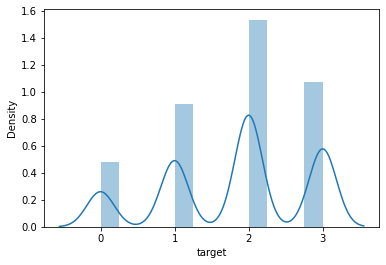

In [273]:
sns.distplot(train_df['target'])

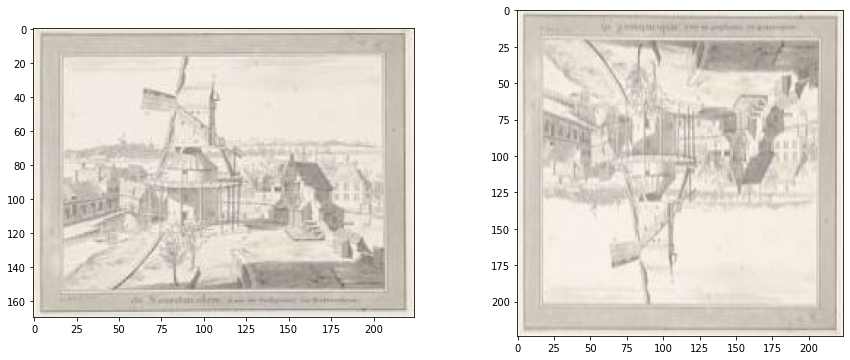

In [274]:
def to_img_path(object_id):
    return os.path.join(photo_dir, f'{object_id}.jpg')

def read_image(object_id):
    image = cv2.imread(to_img_path(object_id))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    # image /= 255.0
    return image

IMG_MEAN = [0.485, 0.456, 0.406]
IMG_STD = [0.229, 0.224, 0.225]

transform = A.Compose([
           A.ToGray(p=0.025),
           A.ToSepia(p=0.025),
           A.HorizontalFlip(p=0.5),
           A.VerticalFlip(p=0.5),
           A.RandomRotate90(p=0.5),
           A.RandomBrightness((-0.5, 0.2), p=0.2),
           A.Blur(blur_limit=(1, 3), p=0.2),
          #  A.Cutout(num_holes=8, max_h_size=24, max_w_size=24, fill_value=0, p=1.0), # 正方形に一部データをdrop outさせる
           A.CoarseDropout(max_holes=16, max_height=24, max_width=24, min_height=8, min_width=8, fill_value=0, p=0.2),
          #  Normalize(mean=IMG_MEAN, std=IMG_STD, p=1.0),
           A.RandomResizedCrop(scale=(1, 1.0), height=224, width=224, p=0.5),
          #  ToTensorV2(p=1.0)
])

img = read_image(train_df['object_id'].iat[78])
img2 = transform(**{'image': img})

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[1].imshow(img2['image'])
axes[0].imshow(img)
# img['image']

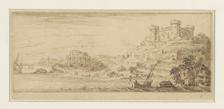

In [8]:
# def to_img_path(object_id):
#     return os.path.join(photo_dir, f'{object_id}.jpg')

# def read_image(object_id):
#     return Image.open(to_img_path(object_id))

# img = read_image(train_df['object_id'].iat[0])
# img

# Model

In [308]:
IMG_MEAN = [0.485, 0.456, 0.406]
IMG_STD = [0.229, 0.224, 0.225]

class AtmaDataset(data.Dataset):
    """atmaCup用にデータ読み込み等を行なうデータ・セット"""
    object_path_key = "object_path"
    label_key = "target"

    @property
    def meta_keys(self):
        retval = [self.object_path_key]

        if self.is_train:
            retval += [self.label_key]

        return retval

    def __init__(self, meta_df: pd.DataFrame, is_train=True):
        """
        args:
            meta_df: 
                画像へのパスと label 情報が含まれている dataframe
                必ず object_path に画像へのパス, target に正解ラベルが入っている必要があります

            is_train:
                True のとき学習用のデータ拡張を適用します.
                False の時は単に size にリサイズを行います
        """

        self.is_train = is_train
        for k in self.meta_keys:
            if k not in meta_df:
                raise ValueError("meta df must have {}".format(k))

        self.meta_df = meta_df.reset_index(drop=True)
        self.index_to_data = self.meta_df.to_dict(orient="index")

        size = SIZE

        if is_train:
          self.transformer = A.Compose([
            A.ToGray(p=0.01),
            A.ToSepia(p=0.01),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            # Normalize(mean=IMG_MEAN, std=IMG_STD, p=1.0),
            A.CoarseDropout(max_holes=16, max_height=24, max_width=24, min_height=8, min_width=8, fill_value=0, p=0.2),
            A.RandomResizedCrop(scale=(0.3, 1.0), height=224, width=224, p=1.0),
            ToTensorV2(p=1.0)
          ])
        else:
          self.transformer = A.Compose([
            # Normalize(mean=IMG_MEAN, std=IMG_STD, p=1.0),
            A.Resize(height=224, width=224, p=1),
            ToTensorV2(p=1.0)
          ])

    def __getitem__(self, index):
        data = self.index_to_data[index]

        obj_path, label = data.get(self.object_path_key), data.get(self.label_key, -1)
        img = cv2.imread(obj_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img /= 255.0
        img = self.transformer(**{'image': img})
        return img['image'], label

    def __len__(self):
        return len(self.meta_df)

In [ ]:
# self.transformer = A.Compose([
#   A.ToGray(p=0.01),
# #  A.ToSepia(p=0.025),
#   A.HorizontalFlip(p=0.5),
#   A.VerticalFlip(p=0.5),
#   A.RandomRotate90(p=0.5),
# #  A.RandomBrightness((-0.5, 0.2), p=0.2),
# #  A.Blur(blur_limit=(1, 3), p=0.2),
# #  A.CoarseDropout(max_holes=16, max_height=24, max_width=24, min_height=8, min_width=8, fill_value=0, p=0.2),
#   Normalize(mean=IMG_MEAN, std=IMG_STD, p=1.0),
#   A.RandomResizedCrop(scale=(0.3, 1.0), height=224, width=224, p=1.0),
#   ToTensorV2(p=1.0)
# ])

In [309]:
train_meta_df = train_df[['target', 'object_id']].copy()
train_meta_df['object_path'] = train_meta_df['object_id'].map(to_img_path)

dataset = AtmaDataset(meta_df=train_meta_df)
loader = data.DataLoader(dataset=dataset, batch_size=54, num_workers=4)

In [310]:
assert torch.cuda.is_available()

DEVICE = torch.device("cuda")
print(DEVICE)

cuda


In [311]:
def train(
    model: nn.Module,
    optimizer: Optimizer,
    train_loader: data.DataLoader
) -> pd.Series:

    # train にすることで model 内の学習時にのみ有効な機構が有効になります (Dropouts Layers、BatchNorm Layers...)
    model.train()

    criterion = nn.MSELoss()

    # ロスの値を保存する用に dict を用意
    metrics = defaultdict(float)
    n_iters = len(train_loader)

    for i, (x_i, y_i) in enumerate(train_loader):
        x_i = x_i.to(DEVICE)
        y_i = y_i.to(DEVICE).reshape(-1, 1).float()

        output = model(x_i)
        loss = criterion(output, y_i)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        metric_i = {
            # loss は tensor object なので item をつかって python object に戻す
            "loss": loss.item()
        }
        for k, v in metric_i.items():
            metrics[k] += v

    for k, v in metrics.items():
        metrics[k] /= n_iters

    return pd.Series(metrics).add_prefix("train_")

# Train

In [312]:
# from sklearn.model_selection import KFold

# fold = KFold(n_splits=5, shuffle=True, random_state=510)
fold = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=510)
if IS_REGR or IS_SOFTLABEL:
  cv = list(fold.split(X=train_df, y=train_df['label'], groups=train_df['art_series_id']))
else:
  cv = list(fold.split(X=train_df, y=train_df['target'], groups=train_df['art_series_id']))

In [313]:
import ttach as tta

def predict(model: nn.Module, loader: data.DataLoader) -> np.ndarray:
    # train とは逆で model 内の学習時にのみ有効な機構がオフになります (Dropouts Layers、BatchNorm Layers...)
    model.eval()

    predicts = []

    # TTA
    transforms = tta.Compose(
        [
            tta.HorizontalFlip(),
            tta.VerticalFlip(),
        ]
    )
    tta_model = tta.ClassificationTTAWrapper(model, transforms)

    for x_i, y_i in loader:

        # 明示的に勾配を計算しないように指定することができます. 
        # この関数ではモデルの更新はせずに単に出力だけを使いますので勾配は不要です.
        with torch.no_grad():
            output = tta_model(x_i.to(DEVICE))

        predicts.extend(output.data.cpu().numpy())

    pred = np.array(predicts).reshape(-1)
    return pred


def calculate_metrics(y_true, y_pred) -> dict:
    """正解ラベルと予測ラベルから指標を計算する"""
    # return regression_metrics(y_true, y_pred)

    return {
        'rmse': mean_squared_error(y_true, y_pred) ** .5
    }


def valid(
    model: nn.Module, 
    y_valid: np.ndarray, 
    valid_loader: data.DataLoader
) -> pd.Series:
    """検証フェーズ
    与えられたモデル・データローダを使って検証フェーズを実行。スコアの dict と予測した値を返す
    """

    pred = predict(model, valid_loader)
    score = calculate_metrics(y_valid, pred)

    valid_score = pd.Series(score)
    return valid_score.add_prefix("valid_"), pred

In [314]:
def run_fold(
    model: nn.Module, 
    train_df: pd.DataFrame, 
    valid_df: pd.DataFrame, 
    y_valid: np.ndarray, 
    output_dir: str, 
    n_epochs) -> np.ndarray:
    """
    train / valid に分割されたデータで学習と同時に検証を行なう
    """
    
    os.makedirs(output_i, exist_ok=True)

    optimizer = Adam(model.parameters(), lr=LERNING_RATE)
    train_dataset = AtmaDataset(meta_df=train_df)
    valid_dataset = AtmaDataset(meta_df=valid_df, is_train=False)

    train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=4)
    valid_loader = data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, num_workers=4)

    score_df = pd.DataFrame()
    valid_score = np.inf
    valid_score_key = "valid_rmse"
    valid_best_pred = None

    for epoch in range(1, n_epochs + 1):
        print(f'start epoch: {epoch}')

        score_train = train(model, optimizer, train_loader)
        score_valid, y_valid_pred = valid(model=model, valid_loader=valid_loader, y_valid=y_valid)


        # --- 学習のロスと検証スコアの値をデータフレームに追加
        row = pd.concat([score_train, score_valid])
        row["epoch"] = epoch
        row = pd.DataFrame([row])
        train_loss = row['train_loss'][0]
        valid_rmse = row['valid_rmse'][0]
        print(f'epoch: {epoch}, train_loss: {train_loss}, valid_rmse: {valid_rmse}')
        # print(tabulate(row, headers=row.columns))
        score_df = pd.concat([score_df, row], ignore_index=True)
        # ---

        # 今の検証スコアと過去最高のスコアを比較
        current_score = score_valid[valid_score_key]
        if current_score < valid_score:
            # スコア改善したときモデルを保存する
            print(f'validation score is improved!! {valid_score:.4f} -> {current_score:.4f}')
            torch.save(
                model.state_dict(), os.path.join(output_dir, 'model_best.pth')
            )
            valid_score = current_score
            valid_best_pred = y_valid_pred

    score_df.to_csv(os.path.join(output_dir, 'score.csv'), index=False)
    return valid_best_pred

In [315]:
%%time
def get_output_dir(n_cv: int):
    return os.path.join(output_dir, 'simple_resnet', f'cv={n_cv}')

oof = np.zeros((len(train_df), ), dtype=np.float32)

for i, (idx_tr, idx_valid) in enumerate(cv):
    print(f'***** fold: {i} *****')
    output_i = get_output_dir(i)
    # model = resnet34(pretrained=False)
    model = resnet18(pretrained=False)
    model.fc = nn.Linear(in_features=512, out_features=1, bias=True)


    model.to(DEVICE)

    oof_i = run_fold(
        model=model, 
        train_df=train_meta_df.iloc[idx_tr], 
        valid_df=train_meta_df.iloc[idx_valid], 
        y_valid=train_meta_df['target'].values[idx_valid],
        output_dir=output_i,
        n_epochs=EPOCHS
    )

    oof[idx_valid] = oof_i

***** fold: 0 *****
start epoch: 1
epoch: 1, train_loss: 4.929910322030385, valid_rmse: 2.179543268348654
validation score is improved!! inf -> 2.1795
start epoch: 2
epoch: 2, train_loss: 3.3399029771486917, valid_rmse: 1.9031218060143762
validation score is improved!! 2.1795 -> 1.9031
start epoch: 3
epoch: 3, train_loss: 2.119616766770681, valid_rmse: 1.666109128611505
validation score is improved!! 1.9031 -> 1.6661
start epoch: 4
epoch: 4, train_loss: 1.363279531399409, valid_rmse: 1.5149671112262504
validation score is improved!! 1.6661 -> 1.5150
start epoch: 5
epoch: 5, train_loss: 1.0161553770303726, valid_rmse: 1.2551055251539154
validation score is improved!! 1.5150 -> 1.2551
start epoch: 6
epoch: 6, train_loss: 0.9116684446732203, valid_rmse: 0.9808867904828258
validation score is improved!! 1.2551 -> 0.9809
start epoch: 7
epoch: 7, train_loss: 0.900971050063769, valid_rmse: 0.9087145873838519
validation score is improved!! 0.9809 -> 0.9087
start epoch: 8
epoch: 8, train_loss: 

In [ ]:
[0.8147, 0.8062, 0.8573, 0.8511, 0.8157]

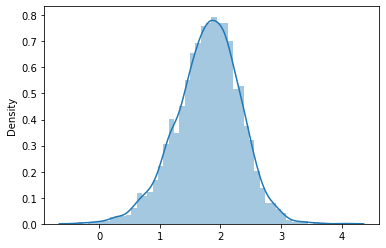

In [316]:
sns.distplot(oof)

In [317]:
import optuna
# mean_squared_error

class OptunaRounder:
  def __init__(self, y_true, y_pred):
    self.y_true = y_true
    self.y_pred = y_pred
    self.labels = np.unique(y_true)

  def __call__(self, trial):
    thresholds = []
    for i in range(len(self.labels)-1):
      low = max(thresholds) if i > 0 else min(self.labels)
      high = max(self.labels)
      t = trial.suggest_uniform(f't{i}', low, high)
      thresholds.append(t)
    opt_y_pred = self.adjust(self.y_pred, thresholds)
    return mean_squared_error(self.y_true, self.y_pred)

  def adjust(self, y_pred, thresholds):
    opt_y_pred = pd.cut(y_pred, [-np.inf] + thresholds + [np.inf], labels=self.labels)
    return opt_y_pred

In [318]:
if IS_REGR:
  objective = OptunaRounder(np.array(train_df['label_log1p']), oof)
  study = optuna.create_study(direction='maximize')
  study.optimize(objective, timeout=100)
elif IS_THRESHOLD:
  objective = OptunaRounder(np.array(train_df['target']), oof)
  study = optuna.create_study(direction='maximize')
  study.optimize(objective, timeout=100)

In [319]:
# Optimized thresholds: [7.363533874332574, 7.419631559526074, 7.471249536725054]
if IS_REGR or IS_THRESHOLD:
  best_thresholds = sorted(study.best_params.values())
  print(f'Optimized thresholds: {best_thresholds}')

In [320]:
if IS_SOFTLABEL:
  oof = np.clip(oof, 0, 3)
print(calculate_metrics(train_df['target'], oof))

if IS_REGR or IS_THRESHOLD:
  oof_bk = oof.copy() # backup
  oof = np.where(oof <= best_thresholds[0], 0, oof)
  oof = np.where((oof > best_thresholds[0]) & (oof <= best_thresholds[1]), 1, oof)
  oof = np.where((oof > best_thresholds[1]) & (oof <= best_thresholds[2]), 2, oof)
  oof = np.where(oof > best_thresholds[2], 3, oof)
  print(f'adjust: {calculate_metrics(train_df["target"], oof)}')

{'rmse': 0.8291873121281108}


In [321]:
def create_metadata(input_df):
    out_df = input_df[['object_id']].copy()
    out_df['object_path'] = input_df['object_id'].map(to_img_path)

    if "target" in input_df:
        out_df["target"] = input_df["target"]

    return out_df

# train と似たようなことをするので、次回から楽したいとおもって `create_metadata` という関数を作りました
test_meta_df = create_metadata(test_df)

# 学習時のデータ拡張はオフにしたいので is_train=False としている
test_dataset = AtmaDataset(meta_df=test_meta_df, is_train=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=128, drop_last=False, num_workers=4)

In [322]:
%%time
test_predictions = []

for i in range(len(cv)):
    print(f'cv: {i}')
    output_i = get_output_dir(i)

    # model = resnet34(pretrained=False)
    model = resnet18(pretrained=False)
    model.fc = nn.Linear(in_features=512, out_features=1, bias=True)
    model_path = os.path.join(output_i, 'model_best.pth')

    model.load_state_dict(torch.load(model_path))
    model.to(DEVICE)
    y_pred_i = predict(model, loader=test_loader)
    test_predictions.append(y_pred_i)

cv: 0
cv: 1
cv: 2
cv: 3
cv: 4
CPU times: user 37 s, sys: 6.18 s, total: 43.2 s
Wall time: 1min 19s


In [323]:
pred_mean = np.array(test_predictions).mean(axis=0)
if IS_SOFTLABEL:
  pred_mean = np.clip(pred_mean, 0, 3)
if IS_REGR or IS_THRESHOLD:
  # pred_mean = np.round(np.e**(pred_mean))
  pred_mean = np.where(pred_mean <= best_thresholds[0], 0, pred_mean)
  pred_mean = np.where((pred_mean > best_thresholds[0]) & (pred_mean <= best_thresholds[1]), 1, pred_mean)
  pred_mean = np.where((pred_mean > best_thresholds[1]) & (pred_mean <= best_thresholds[2]), 2, pred_mean)
  pred_mean = np.where(pred_mean > best_thresholds[2], 3, pred_mean)

In [324]:
np.unique(pred_mean, return_counts=True)

(array([-1.8954516e-03,  5.5987556e-02,  7.8489505e-02, ...,
         3.5336750e+00,  3.6241775e+00,  3.8496375e+00], dtype=float32),
 array([1, 1, 1, ..., 1, 1, 1]))

In [325]:
import datetime
now = datetime.datetime.now()
print(now)
# sub.to_csv(f'../output/submission_{now.strftime("%m%d_%H%M")}.csv', index=False)

2021-07-21 18:33:25.568875


In [326]:
pred_mean = np.array(test_predictions).mean(axis=0)

pd.DataFrame({
    "target": pred_mean
}).to_csv(os.path.join(output_dir, f"submission_{now.strftime('%m%d_%H%M')}.csv"), index=False)